## Notebook Imports

In [1]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
%matplotlib inline

## Constants

In [2]:
EXAMPLE_FILE = r'SpamData\01_Processing\practice_email.txt'
SPAM_1_PATH = r'SpamData\01_Processing\spam_assassin_corpus\spam_1'
SPAM_2_PATH = r'SpamData\01_Processing\spam_assassin_corpus\spam_2'
EASY_NONSPAM_1_PATH = r'SpamData\01_Processing\spam_assassin_corpus\easy_ham_1'
EASY_NONSPAM_2_PATH = r'SpamData\01_Processing\spam_assassin_corpus\easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
DATA_JSON_FILE = r'SpamData\01_Processing\email-text-data.json'

## Reading Files

In [3]:
stream = open(EXAMPLE_FILE , encoding='latin-1')
message = stream.read()
stream.close()
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
stream = open(EXAMPLE_FILE , encoding='latin-1')
lines = []
is_body = False
for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
    
stream.close()
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email Body Extraction

In [5]:
def email_body_generator(path):
    for root,dirnames, filenames in walk(path):
        for file_name in filenames:
            file_path = join(root,file_name)
            stream = open(file_path , encoding='latin-1')
            lines = []
            is_body = False
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(lines)
            
            yield file_name,email_body

        

In [6]:
def df_from_directory(path,classification):
    rows = []
    row_names = []
    
    for file_name,email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,index=row_names)

In [7]:
spam_emails = df_from_directory(SPAM_1_PATH,SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))

In [8]:
spam_emails.shape

(1898, 2)

In [9]:
ham_emails.shape

(3901, 2)

In [10]:
data = pd.concat([spam_emails,ham_emails])

In [11]:
data.shape

(5799, 2)

In [12]:
data.tail()

,MESSAGE,CATEGORY
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0
01400.f897f0931e461e7b2e964d28e927c35e,"Hi there,\n\n\n\nNow this is probably of no us...",0


# Data Cleaning: Checking for Missing Values

In [13]:
#check if any message bodies are null
data.MESSAGE.isnull().sum()

0

In [14]:
#check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).sum()

3

In [15]:
data.loc[data['MESSAGE'].str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [16]:
data.drop(['cmds'],inplace=True)

In [17]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [18]:
documents_ids = range(0,len(data.index))
documents_ids

range(0, 5796)

In [19]:
data['DOC_ID'] = documents_ids

In [20]:
data['FILE_NAME'] = data.index
data.head()
data.set_index('DOC_ID',inplace=True)

In [21]:
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


# Save to file Using pandas

In [22]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages visualised(Pie Charts)

In [23]:
data['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [24]:
amount_of_spam = data['CATEGORY'].value_counts()[1]
amount_of_ham = data['CATEGORY'].value_counts()[0]

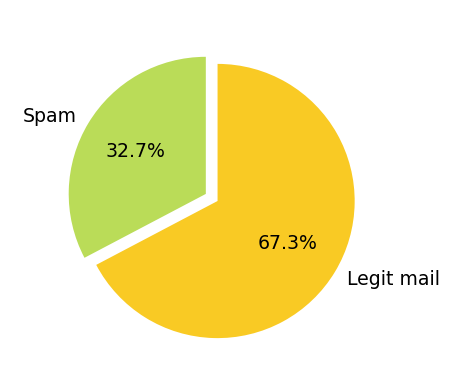

In [25]:
category_names = ['Spam','Legit mail']
sizes=[amount_of_spam,amount_of_ham]
custom_colors = ['#badc58','#f9ca24']
plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,autopct='%1.1f%%',colors=custom_colors,explode=[0,0.1])
plt.show()

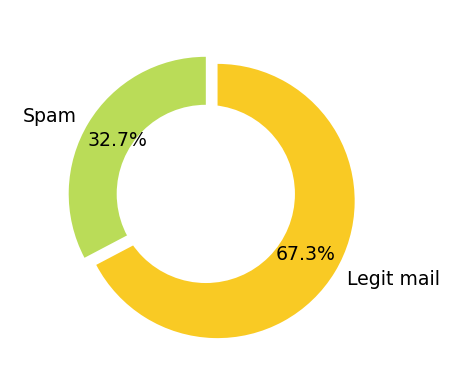

In [26]:
category_names = ['Spam','Legit mail']
sizes=[amount_of_spam,amount_of_ham]
custom_colors = ['#badc58','#f9ca24']
plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,autopct='%1.1f%%',colors=custom_colors,explode=[0,0.1],pctdistance=0.75)

#draw circle
centre_circle = plt.Circle((0,0),radius = 0.65 ,fc='white')
plt.gca().add_artist(centre_circle)
plt.show()

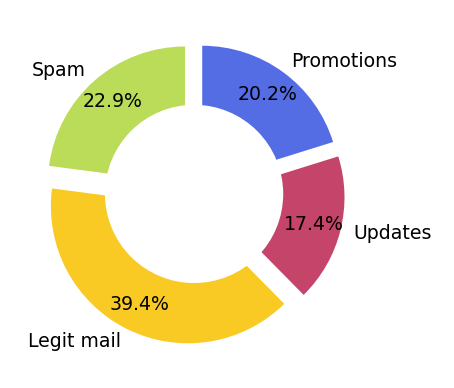

In [27]:
category_names = ['Spam','Legit mail','Updates','Promotions']
sizes=[25,43,19,22]
custom_colors = ['#badc58','#f9ca24','#c44569','#546de5']
plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,autopct='%1.1f%%',colors=custom_colors,explode=[0.1,0.1,0.1,0.1],pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0),radius = 0.65 ,fc='white')
plt.gca().add_artist(centre_circle)
plt.show() 

 # Natural Language Processing

### Text Pre-processing

In [28]:
#convert to lower case

msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources(Tokenizer & Stopwords)

In [29]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aashish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Tokenising

In [31]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stopwords

In [32]:
stop_words = set(stopwords.words('english'))

In [33]:
if 'hello' in stop_words: print('Found it!')
else: print('Nope. Not in here')

Nope. Not in here


In [34]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be'
words = word_tokenize(msg.lower())
filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']


## Word Stems and Stemming

In [35]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
Nobody expects the Spanish Inquistion!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    stemmed_word = stemmer.stem(word)
    if word not in stop_words:
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquist', '!']


## Removing Punctuation

In [36]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.??? \
Nobody expects the Spanish Inquistion!'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word.isalpha():
        stemmed_word = stemmer.stem(word)
        if word not in stop_words:
            filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquist']


## Removing HTML tags from Emails

In [37]:
data.at[2,'MESSAGE']

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [38]:
soup = BeautifulSoup(data.at[2,'MESSAGE'],'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [39]:
txt = soup.get_text()

In [40]:
print(txt)

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417





## Functions for Email Processing

In [41]:
def clean_message(message,stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    #Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        #Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    
    return filtered_words

## Email Body with no HTML Tags

In [48]:
def clean_msg_no_html(message,stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    #Removing HTML Tags
    
    soup = BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    
    #Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        #Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
            
    
    
    return filtered_words

In [49]:
clean_msg_no_html(str(data['MESSAGE'].loc[2]))

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

# Apply Cleaning annd Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [72]:
data['MESSAGE'].iloc[0:3]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

In [ ]:
data.iat[]

In [73]:
# Use apply to clean all the messages
%%time
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\Aashish\anaconda3\lib\site-packages\bs4\__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 49.3 s


In [75]:
type(nested_list)

pandas.core.series.Series

## Using Logic to slice DataFrame

In [76]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [77]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [78]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [79]:
nested_list_ham.head()

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
Name: MESSAGE, dtype: object

In [82]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [86]:
total_words_spam_list = [words for sublist in nested_list_spam for words in sublist]
print("The total no of words in spam emails are:",len(total_words_spam_list))

The total no of words in spam emails are: 317499


In [87]:
total_words_ham_list = [words for sublist in nested_list_ham for words in sublist]
print("The total no of words in normal emails are:",len(total_words_ham_list))

The total no of words in normal emails are: 442061


In [98]:
# The 10 most common words in Spam and Legit Emails
from collections import Counter
Counter = Counter(total_words_spam_list)
most_occur = Counter.most_common(10)
print('The 10 most common words in spam emails are:\n')
print(most_occur)

#Method 2
#Use pandas Series to convert the total words list into a series then use pandas value_counts() method.

The 10 most common words in spam emails are:

[('http', 3097), ('email', 3090), ('free', 2585), ('click', 2058), ('receiv', 1989), ('list', 1971), ('get', 1914), ('pleas', 1852), ('busi', 1792), ('order', 1746)]


In [102]:
from collections import Counter
counter_legit = Counter(total_words_ham_list)
most_occured_legit = counter_legit.most_common(10)
print('The 10 most common words in legit emails are:\n')
print(most_occured_legit)

The 10 most common words in legit emails are:

[('http', 7563), ('use', 3633), ('list', 2880), ('one', 2373), ('get', 2286), ('mail', 2255), ('would', 2003), ('like', 1931), ('messag', 1849), ('work', 1800)]
